# Modelo de 99% com 10% do dataset

Esse notebook visa seguir os passos apresentados para o treinamento do modelo proposto por [ahmadmustafa12](https://www.kaggle.com/code/ahmadmustafa12/transfer-learning-99-accuracy-tensorflow). Contudo, dado o tempo de processamento, optou-se por reduzir o dataset, pegando apenas os primeiros 10% das iamgens, tanto de treinamento quanto de teste.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os

In [3]:
trainpath = os.listdir("../train")
testpath = os.listdir("../test")

In [4]:
porcentagem_do_dataset = .1

In [5]:
train_data = trainpath[ :int(len(trainpath) * porcentagem_do_dataset) ]
test_data = testpath[ :int(len(testpath) * porcentagem_do_dataset) ]

In [6]:
print(len(train_data), len(test_data))

1800 360


In [9]:
train_df = pd.DataFrame(train_data, columns=["Filepath"])
test_df = pd.DataFrame(test_data, columns=['Filepath'])

# train_df.apply( lambda x : x["Filepath"] = "../../train/" + x["Filepath"] ) 
train_df["Filepath"] = ( "../train/" + train_df["Filepath"] ) 
test_df["Filepath"] = ( "../test/" + test_df["Filepath"] ) 

In [10]:
train_df.head()

,Filepath
0,../train/00048bba-979b-4f84-b833-5bbbb082b582_...
1,../train/000547a2-d456-4b16-b351-12ca9b40e390_...
2,../train/000cac8e-fcf0-4f8c-bd16-c257d1e6d7a8_...
3,../train/000d9961-8136-4dee-9820-86e178777958_...
4,../train/0010095b-2e3d-4517-a511-1f688c378f96_...


In [11]:
train_df['Label'] = train_df['Filepath'].apply(lambda a: a[-6:-4])
test_df['Label'] = test_df['Filepath'].apply(lambda a: a[-6:-4])

In [12]:
train_df.head()

,Filepath,Label
0,../train/00048bba-979b-4f84-b833-5bbbb082b582_...,0L
1,../train/000547a2-d456-4b16-b351-12ca9b40e390_...,0L
2,../train/000cac8e-fcf0-4f8c-bd16-c257d1e6d7a8_...,2L
3,../train/000d9961-8136-4dee-9820-86e178777958_...,0L
4,../train/0010095b-2e3d-4517-a511-1f688c378f96_...,5L


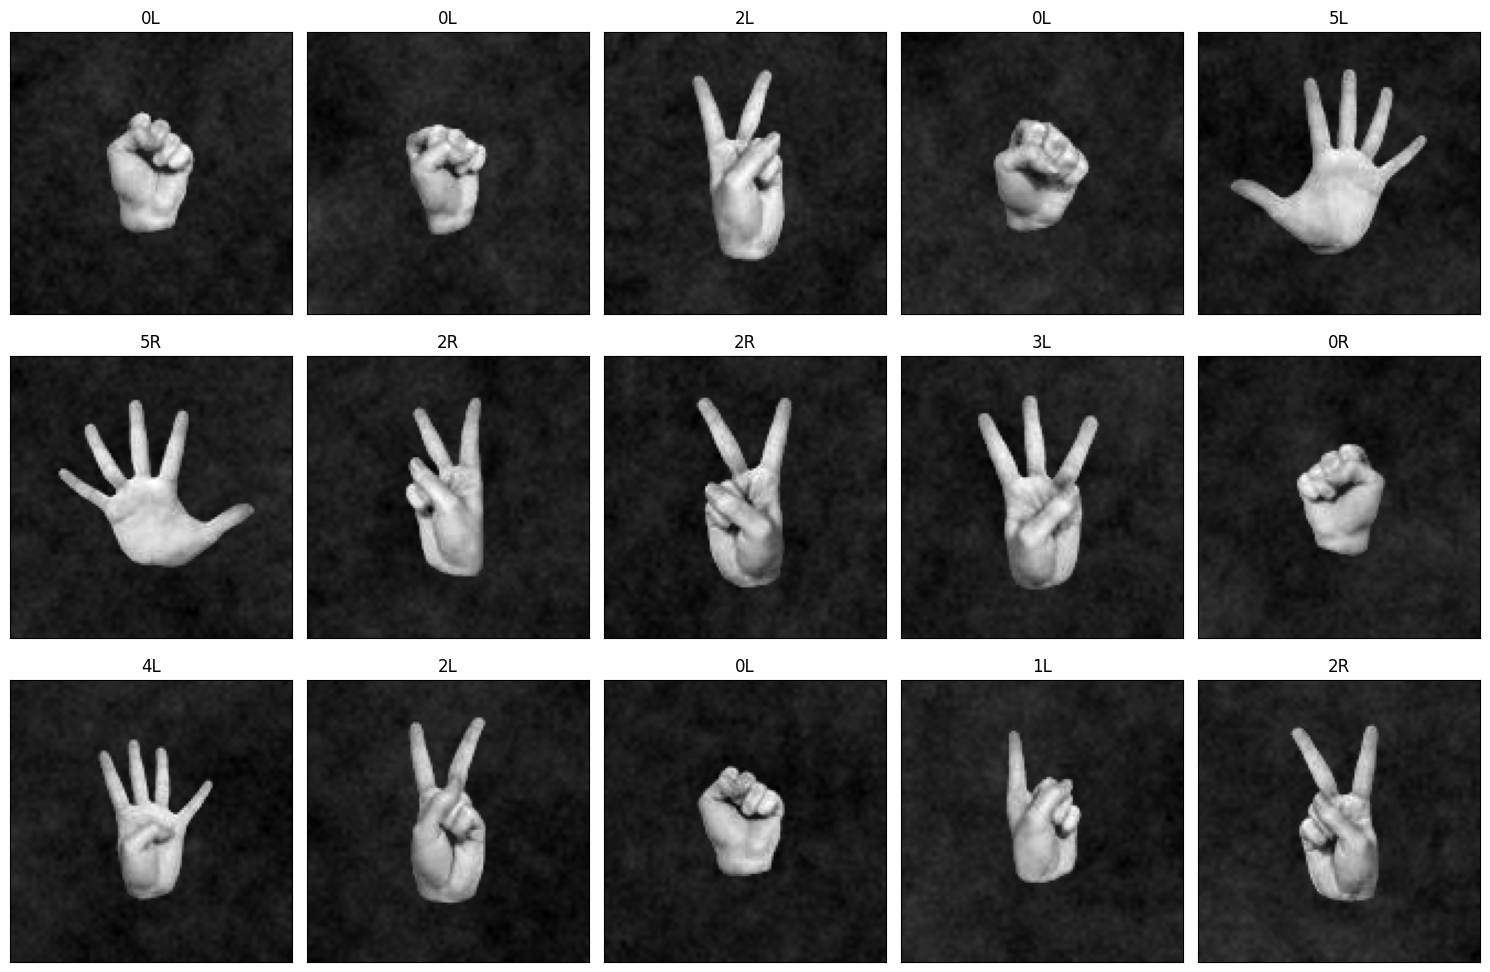

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]), cmap='gray')
    ax.set_title(train_df.Label[i])
plt.tight_layout()
plt.show()

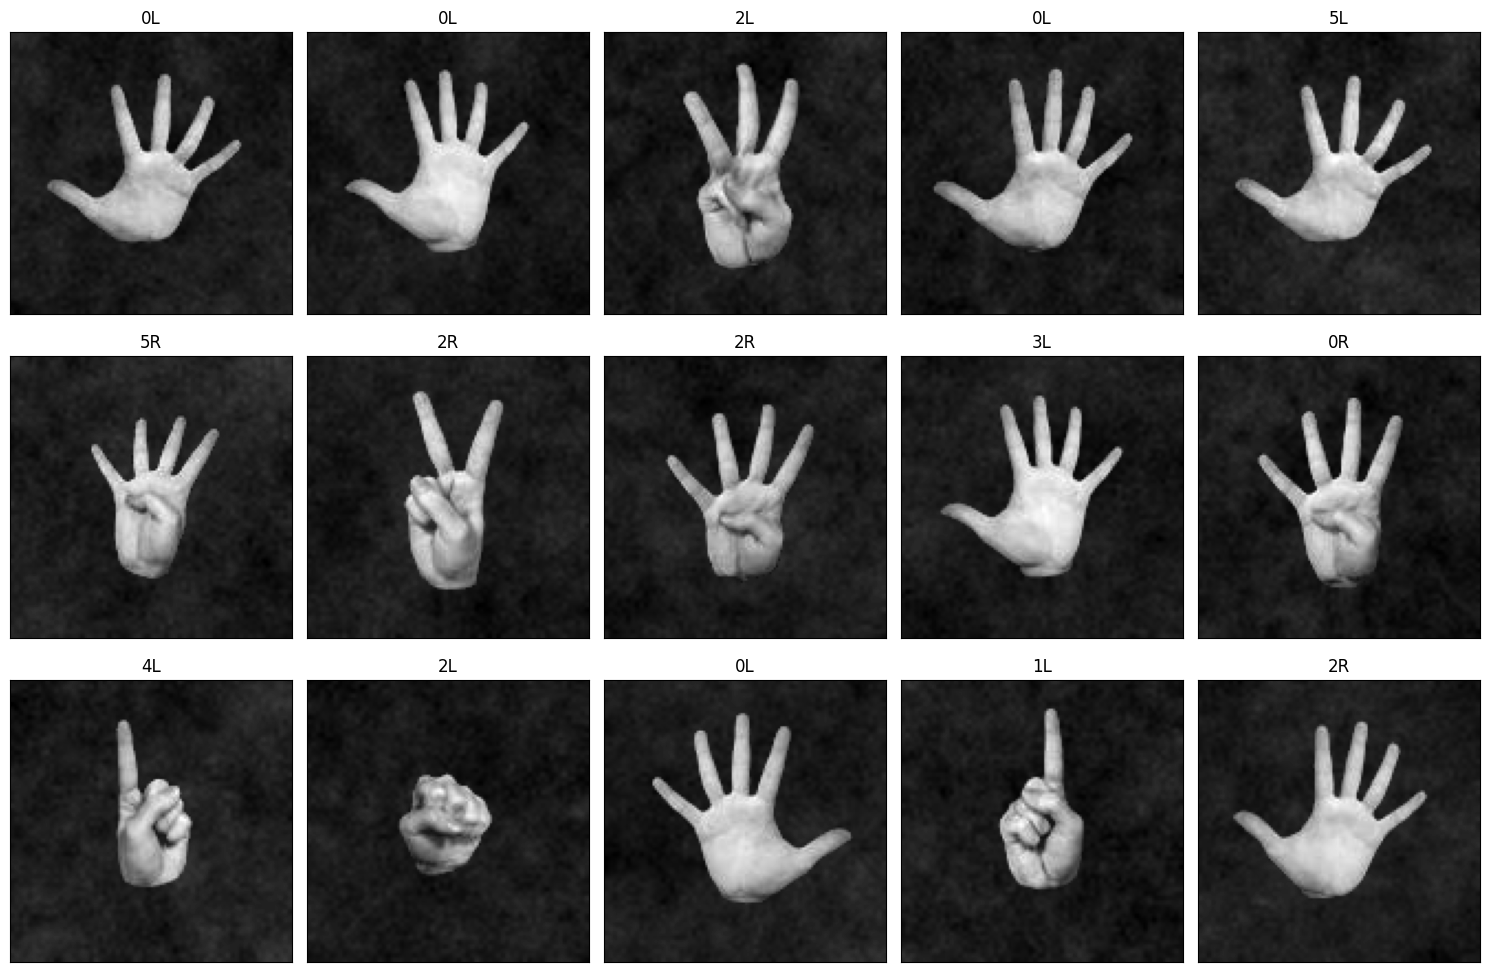

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath[i]), cmap='gray')
    ax.set_title(train_df.Label[i])
plt.tight_layout()
plt.show()

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_VGG16

In [13]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input_VGG16,
    validation_split=0.1
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input_VGG16
)

train_images_flow = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training',
)

val_images_flow = train_generator.flow_from_dataframe( 
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='validation', 
)

test_images_flow = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False, 
)

Found 1620 validated image filenames belonging to 12 classes.
Found 180 validated image filenames belonging to 12 classes.
Found 360 validated image filenames belonging to 12 classes.


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [16]:
feature_extractor = VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

feature_extractor.trainable = False

In [17]:
feature_extractor.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
classifier = Sequential([
    Dense(128, activation = 'relu'),
    Dense(12, activation ='softmax')
], name='Classifier')

In [19]:
complete_model = Sequential([
    feature_extractor,
    classifier
], name='CompleteModel')

In [22]:
#complete_model.build()
#tf.keras.utils.plot_model(complete_model, show_shapes=True)

In [23]:
complete_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
history = complete_model.fit(
    train_images_flow,
    validation_data=val_images_flow,
    batch_size = 32,
    epochs=3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/3


C:\Users\mauro\Desktop\Cursos\Atlantico Bootcamp - Machine Learning\avanti-ml-equipe-6\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.3705 - loss: 2.0916 - val_accuracy: 0.8889 - val_loss: 0.4536
Epoch 2/3
51/51 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.8881 - loss: 0.4031 - val_accuracy: 0.8833 - val_loss: 0.3004
Epoch 3/3
51/51 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.9252 - loss: 0.2491 - val_accuracy: 0.9444 - val_loss: 0.1915


In [29]:
process_time = 161 + 151 + 160 
_minutes = process_time // 60 
_seconds = process_time % 60 
print(f"Tempo de processamento foi de {_minutes}:{_seconds}")

Tempo de processamento foi de 7:52


In [25]:
loss, acc = complete_model.evaluate(test_images_flow)

12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.9264 - loss: 0.2140


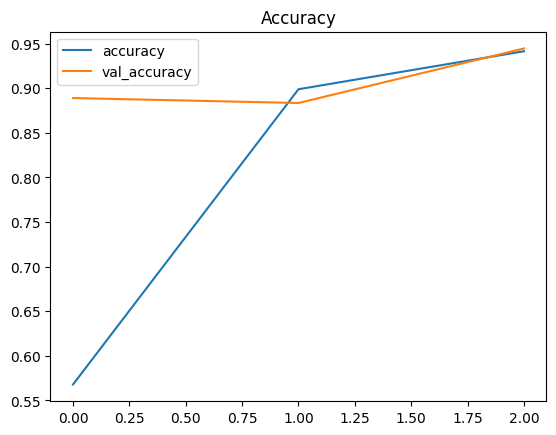

In [26]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

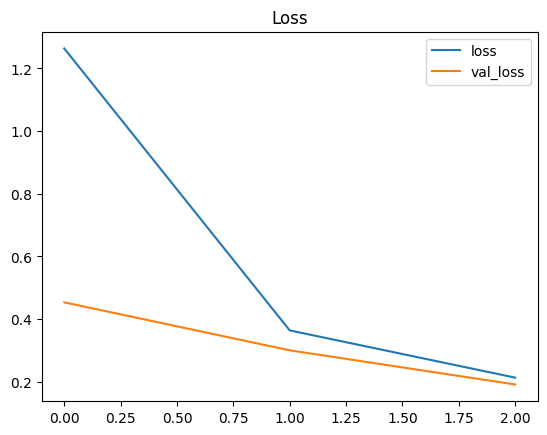

In [27]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# Resultados :

Usando apenas 10% dos dados, obteve-se uma acurácia de **92.64%** e um tempo de treinamento de **7 minutos e 52 segungos**